In [1]:
# Necessary libraries

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import random
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

%matplotlib inline

In [2]:
# Load data

train_file_path = './data/train.p'
valid_file_path = './data/valid.p'
test_file_path = './data/test.p'

with open(train_file_path, mode='rb') as f1:
    train_dict = pickle.load(f1)
with open(valid_file_path, mode='rb') as f2:
    valid_dict = pickle.load(f2)
with open(test_file_path, mode='rb')as f3:
    test_dict = pickle.load(f3)

In [3]:
# Get features and labels (as numpy arrays from th dictionaries)

x_train_np,y_train_np = train_dict['features'],train_dict['labels']
x_valid_np,y_valid_np = valid_dict['features'],valid_dict['labels']
x_test_np,y_test_np = test_dict['features'],test_dict['labels']

print('Train Shape:',x_train_np.shape)
print('Valid Shape:',x_valid_np.shape)
print('Test Shape:',x_test_np.shape)

num_classes = len(set(y_train_np))
print('Number of classes:',num_classes)

Train Shape: (34799, 32, 32, 3)
Valid Shape: (4410, 32, 32, 3)
Test Shape: (12630, 32, 32, 3)
Number of classes: 43


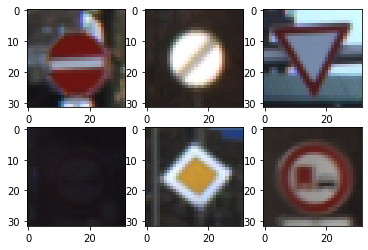

In [4]:
# Visualise few images

rows = 2
cols = 3
fig = plt.figure()

for pos in range(1,rows*cols+1):
    idx = random.randint(1,len(x_train_np))
    img = x_train_np[idx]
    fig.add_subplot(rows,cols,pos)
    plt.imshow(img)
plt.show()

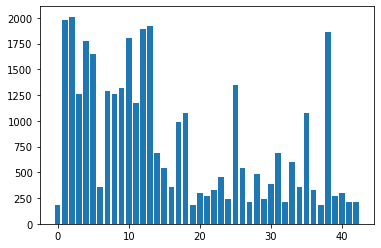

In [5]:
# Class wise training data count

plt.bar(range(num_classes),np.bincount(y_train_np))
plt.show()

In [6]:
# Image Transforms

train_transforms = transforms.Compose([transforms.ToPILImage(),transforms.Grayscale(num_output_channels=1),transforms.ToTensor()])
valid_transforms = transforms.Compose([transforms.ToPILImage(),transforms.Grayscale(num_output_channels=1),transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.ToPILImage(),transforms.Grayscale(num_output_channels=1),transforms.ToTensor()])

In [7]:
# Create Tensor Dataset

class CreateDataset(Dataset):
    def __init__(self,x,y,transforms=None):
        self.x = x
        self.y = y
        self.transforms = transforms
    def __getitem__(self,idx):
        x_batch = self.x[idx]
        y_batch = self.y[idx]
        if self.transforms:
            x_batch = self.transforms(x_batch)
        return x_batch,y_batch
    def __len__(self):
        return len(self.x)
    

train_dataset = CreateDataset(x_train_np,y_train_np,train_transforms)
valid_dataset = CreateDataset(x_valid_np,y_valid_np,valid_transforms)
test_dataset = CreateDataset(x_test_np,y_test_np,test_transforms)

In [8]:
# Create Dataloaders

train_valid_bs = 1000
test_bs = 1000

train_dataloader = DataLoader(train_dataset,batch_size=train_valid_bs,shuffle=True)
valid_dataloader = DataLoader(valid_dataset,batch_size=train_valid_bs)
test_dataloader = DataLoader(test_dataset,batch_size=test_bs)

In [9]:
# Model class

class TrafficSignRecogniser(nn.Module):
    def __init__(self):
        super(TrafficSignRecogniser, self).__init__()
        self.conv1 = nn.Conv2d(1, 100, 5)
        self.conv1_bn = nn.BatchNorm2d(100)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, 3)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, 1)
        self.conv3_bn = nn.BatchNorm2d(250)
        self.fc1 = nn.Linear(250 * 3 * 3, 350)
        self.fc1_bn = nn.BatchNorm1d(350)
        self.fc2 = nn.Linear(350, 43)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))
        x = x.view(-1, 250 * 3 * 3)
        x = F.elu(self.fc1(x))
        x = self.dropout(self.fc1_bn(x))
        x = self.fc2(x)
        return x

In [10]:
# Hyperparameters, Criterion, Optimiser

model = TrafficSignRecogniser()
model.cuda()

epochs = 30
lr = 0.1
print_freq = 10
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(),lr=lr)

In [11]:
def train(train_dataloader,model,criterion,optimiser,device,epoch):
    total_loss = 0
    for bc,(x,y) in enumerate(train_dataloader):
        model.train()
        inp = x.to(device)
        tar = y.type(torch.LongTensor).to(device) #nn.crossentropy accepts only long dtype as targets
        pred = model(inp)
        loss = criterion(pred,tar)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        total_loss += loss.item()
    train_avg_loss = total_loss / len(train_dataloader)
    print('Training Loss:',train_avg_loss)
    
            
def validate(valid_dataloader,model,criterion,device,epoch):
    total_valid_loss = 0
    model.eval()
    for x,y in valid_dataloader:
        inp = x.to(device)
        tar = y.type(torch.LongTensor).to(device) #nn.crossentropy accepts only long dtype as targets
        pred = model(inp)
        loss = criterion(pred,tar)
        total_valid_loss += loss.item()
    average_valid_loss = total_valid_loss / len(valid_dataloader)
    print('Validation loss:',average_valid_loss)
    
    
def calculate_test_accuracy(test_dataloader,model):
    sum_accuracy = 0
    for x,y in test_dataloader:
        model.eval()
        inp = x.to(device)
        tar = y.type(torch.LongTensor).to(device) #nn.crossentropy accepts only long dtype as targets
        pred = model(inp)
        max_idx = torch.max(pred,1)[1]
        sum_accuracy += (torch.eq(max_idx,tar)).float().mean()
    avg_accuracy = sum_accuracy / len(test_dataloader) * 100
    return avg_accuracy.item()

In [ ]:
# Train

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

for epoch in range(epochs):
    print('Epoch:',epoch+1)
    train(train_dataloader,model,criterion,optimiser,device,epoch)
    validate(valid_dataloader,model,criterion,device,epoch)

In [13]:
# Test

test_accuracy = calculate_test_accuracy(test_dataloader,model)
print('Test accuracy:',test_accuracy)

Test accuracy: 94.4034194946289


In [14]:
# Remove cuda cache

torch.cuda.empty_cache()